In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
import constants as c

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [2]:
synthfirm_all = read_csv('outputs_SF/synthetic_firms.csv', low_memory=False)
sf_map = gpd.read_file('inputs_SF/SFBay_freight.geojson')
mesozone_id_lookup = read_csv('inputs_SF/zonal_id_lookup_final.csv')

lehd_validation = read_csv('inputs_SF/LEHD_employment.csv')
sf_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859..."
1,060510001011,6051,4047.0,"MULTIPOLYGON (((-118.94774 37.77604, -118.9459..."
2,060930002001,6093,8981.0,"MULTIPOLYGON (((-122.25152 41.75726, -122.2491..."
3,060570009003,6057,4462.0,"MULTIPOLYGON (((-120.85050 39.39899, -120.8491..."
4,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119..."


In [3]:
print(synthfirm_all.columns)
firm_by_zone = synthfirm_all.groupby(['MESOZONE']).agg({'BusID':'count',
                                                       'Emp':'sum'})
firm_by_zone = firm_by_zone.reset_index()
firm_by_zone.columns = ['MESOZONE', 'firm_count', 'employment_count']
firm_by_zone.head(5)

print(firm_by_zone[['firm_count', 'employment_count']].sum())

Index(['CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE'],
      dtype='object')
firm_count          8.390414e+06
employment_count    1.075726e+08
dtype: float64


In [4]:
print(mesozone_id_lookup.columns)
firm_by_zone = pd.merge(firm_by_zone, mesozone_id_lookup, on = 'MESOZONE', how = 'left')
firm_by_zone.head(5)

Index(['Unnamed: 0', 'GEOID', 'CBPZONE', 'MESOZONE', 'FAFID', 'FAFNAME'], dtype='object')


,MESOZONE,firm_count,employment_count,Unnamed: 0,GEOID,CBPZONE,FAFID,FAFNAME
0,1,30,4498.258503,5072,60014001001,6001,64,San Francisco
1,2,34,255.635178,9148,60014002001,6001,64,San Francisco
2,3,48,351.784439,1029,60014002002,6001,64,San Francisco
3,4,34,975.381942,10526,60014003001,6001,64,San Francisco
4,5,32,343.366513,8963,60014003002,6001,64,San Francisco


In [5]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([64, 62, 69, 65])]
print(firm_in_study_area.firm_count.sum())
# sf_map_with_firm = sf_map.merge(firm_in_austin, on='MESOZONE', how='inner')
# sf_map_with_firm.head(5)
synthfirm_in_study_area = synthfirm_all.loc[synthfirm_all['MESOZONE'] < 20000]
print(synthfirm_in_study_area.Emp.sum())
print(len(synthfirm_all.Industry_NAICS6_Make.unique()))
print(len(synthfirm_in_study_area.Industry_NAICS6_Make.unique()))

synthfirm_in_study_area.head(5)

421169
5827560.989253243
389
383


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE
123,6101,62,1,1111A0,3,1.000000,124,10044
124,6011,69,1,1111A0,3,1.000000,125,1313
1043,6067,62,1,1111A0,3,1.000000,1044,5509
1044,6113,62,1,1111A0,3,4.666667,1045,10462
1045,6113,62,1,1111A0,3,4.666667,1046,10451


5827560.989253243


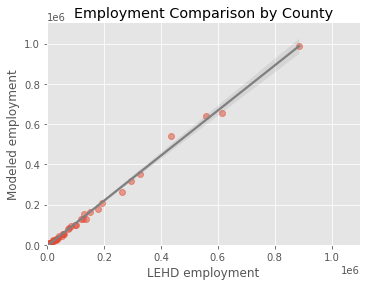

In [8]:
# compare to LEHD data
#lehd_validation.head(5)
lehd_firm_by_county = \
lehd_validation.loc[lehd_validation['industry'] == '0']
firm_in_study_area_by_county = firm_in_study_area.groupby('CBPZONE')[['employment_count']].sum()
firm_in_study_area_by_county = firm_in_study_area_by_county.reset_index()
# print(firm_in_study_area_by_county.head(5))

lehd_firm_by_county = lehd_firm_by_county.groupby('geography')[['EmpS']].mean()
lehd_firm_by_county = lehd_firm_by_county.reset_index()
# print(lehd_firm_by_county.head(5))
firm_comparison_by_county = pd.merge(lehd_firm_by_county, 
                                     firm_in_study_area_by_county,
                                     left_on = 'geography',
                                     right_on = 'CBPZONE',
                                     how = 'inner')
firm_comparison_by_county.columns = ['County', 'LEHD employment', 'CBPZONE', 'Modeled employment']
print(firm_comparison_by_county['Modeled employment'].sum())
firm_comparison_by_county.head(5)
plt.style.use('ggplot')
g = sns.lmplot(
    data=firm_comparison_by_county,
    x="LEHD employment", y="Modeled employment", 
    height=4, aspect = 1.3, 
    line_kws={'color': 'grey'}, scatter_kws = {'alpha':0.5})
plt.title('Employment Comparison by County')
plt.xlim([0, 1100000])
plt.ylim([0, 1100000])
plt.savefig('plots_SF/SF_emp_by_county_validation.png', dpi = 200,
           bbox_inches = 'tight')

5425064.5
5827560.989253243


/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_88451/2779597804.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_88451/2779597804.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
/var/folders/w6/7qcyt43n

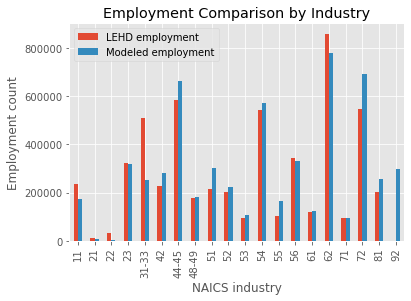

In [11]:
# compare to LEHD data
#lehd_validation.head(5)
industry_lookup = {'11':'11', '21':'21', '22':'22', '23':'23',
                   '31':'31-33', '32':'31-33', '33':'31-33',
                   '42':'42', '44':'44-45', '45':'44-45', '4A': '44-45',
                   '48':'48-49', '49':'48-49', '51':'51',
                   '52':'52', '53':'53', '54':'54', '55':'55',
                   '56':'56', '61':'61', '62':'62', '71':'71',
                   '72':'72', '81':'81', '92':'92', 'S0': '92'}
selected_counties = firm_comparison_by_county.County.unique()
lehd_firm_by_industry = lehd_validation.loc[lehd_validation['industry'] != '0']

# print(lehd_firm_by_industry.industry.unique())

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['geography', 'industry'])[['EmpS']].mean()

lehd_firm_by_industry = lehd_firm_by_industry.reset_index()
lehd_firm_by_industry = \
lehd_firm_by_industry.loc[lehd_firm_by_industry['geography'].isin(selected_counties)]

lehd_firm_by_industry = lehd_firm_by_industry.groupby(['industry'])[['EmpS']].sum()
print(lehd_firm_by_industry['EmpS'].sum())

print(synthfirm_in_study_area.loc[:, 'Emp'].sum())
synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].astype(str)
synthfirm_in_study_area.loc[:, 'NAICS2'] = synthfirm_in_study_area.loc[:, 'Industry_NAICS6_Make'].str[:2]
# print(synthfirm_in_study_area.loc[:, 'NAICS2'].unique())
synthfirm_in_study_area.loc[:, 'industry'] = synthfirm_in_study_area.loc[:, 'NAICS2'].map(industry_lookup)

firm_in_study_area_by_industry = synthfirm_in_study_area.groupby(['industry'])[['Emp']].sum()
# print(firm_in_study_area_by_industry['Emp'].sum())
firm_in_study_area_by_industry = firm_in_study_area_by_industry.reset_index()
firm_comparison_by_industry = pd.merge(lehd_firm_by_industry,
                                       firm_in_study_area_by_industry,
                                       on = 'industry', how = 'inner')

firm_comparison_by_industry.columns = ['Industry', 'LEHD employment',  'Modeled employment']
# print(firm_comparison_by_industry['SynthFirm employment'].sum())
# print(firm_comparison_by_industry.head(5))
plt.style.use('ggplot')
firm_comparison_by_industry.plot(kind = 'bar',
    x="Industry")
plt.xlabel('NAICS industry')
plt.ylabel('Employment count')
plt.title('Employment Comparison by Industry')
plt.savefig('plots_SF/SF_emp_by_industry_validation.png', dpi = 200)

In [10]:
firm_in_study_area = firm_by_zone.loc[firm_by_zone['FAFID'].isin([64])]
sf_map_with_firm = sf_map.merge(firm_in_study_area, on='MESOZONE', how='inner')
sf_map_with_firm.head(5)

,GEOID_x,CBPZONE_x,MESOZONE,geometry,firm_count,employment_count,Unnamed: 0,GEOID_y,CBPZONE_y,FAFID,FAFNAME
0,060411242004,6041,3751.0,"MULTIPOLYGON (((-122.48795 37.89798, -122.4859...",68,596.351212,0,60411242004,6041,64,San Francisco
1,060750108001,6075,5684.0,"MULTIPOLYGON (((-122.41684 37.79660, -122.4119...",68,1275.957857,4,60750108001,6075,64,San Francisco
2,060014227001,6001,394.0,"MULTIPOLYGON (((-122.24986 37.86749, -122.2484...",37,594.606344,7,60014227001,6001,64,San Francisco
3,060750611002,6075,6224.0,"MULTIPOLYGON (((-122.40790 37.79406, -122.4048...",66,5034.008539,8,60750611002,6075,64,San Francisco
4,060855094013,6085,8378.0,"MULTIPOLYGON (((-122.11699 37.40350, -122.1157...",45,533.376781,9,60855094013,6085,64,San Francisco


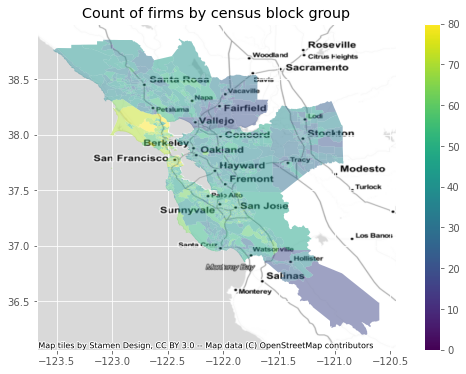

In [13]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'firm_count', 
                           vmin=0, vmax=80, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.Stamen.TonerLite)
plt.title('Count of firms by census block group')
plt.savefig('plots_SF/sf_region_firm_count.png', dpi = 200)

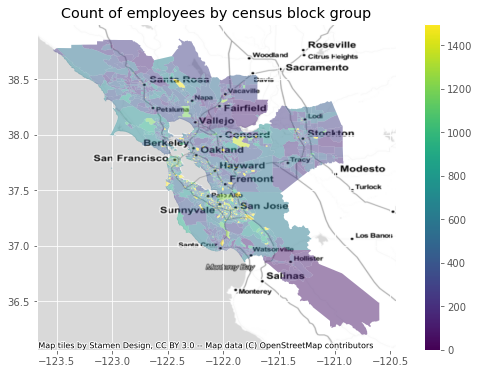

In [15]:
ax = sf_map_with_firm.plot(figsize = (10,6), column = 'employment_count', 
                            vmin=0, vmax=1500, alpha = 0.5, legend=True)
cx.add_basemap(ax, crs = 'EPSG:4326',source = cx.providers.Stamen.TonerLite)
plt.title('Count of employees by census block group')
plt.savefig('plots_SF/sf_region_emp_count.png', dpi = 200)